#  Прогнозирование заказов такси

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as ltb
from sklearn.metrics import mean_squared_error

In [2]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# проверим данные на последовательность
data.index.is_monotonic

True

In [4]:
df_rolling = data.copy()
df_sezon_onehour = data.copy()
df_sezon_oneday = data.copy()

# делаем ресемплирование на 1 час
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 2. Анализ

Первое что рассмотрим, это скользящую средную.

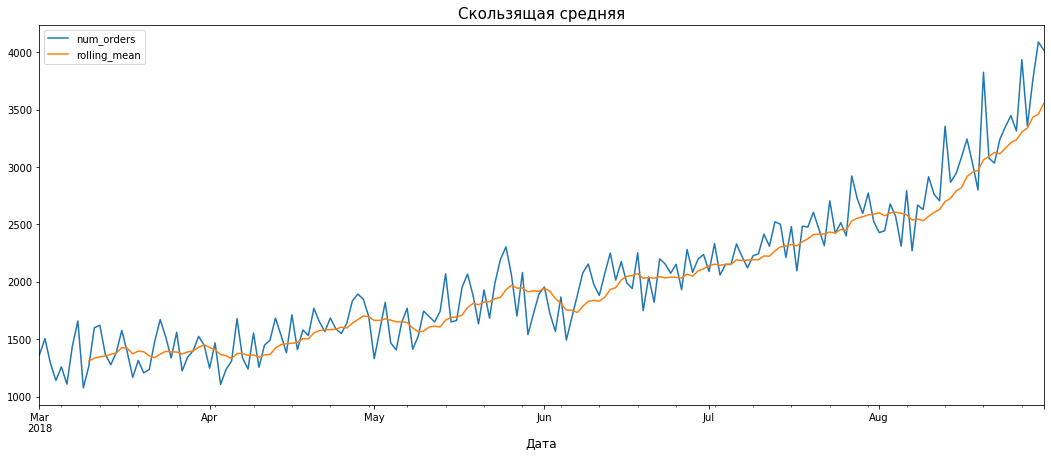

In [5]:
# для удобства анализа ресемплируем на 1 день
df_rolling = df_rolling.resample('1D').sum()

df_rolling['rolling_mean'] = df_rolling.rolling(10).mean()
df_rolling.plot(figsize=(18, 7))
plt.title('Скользящая средняя', size=(15))
plt.xlabel('Дата', size=(12))
plt.show()

Как видно по графику, люди всё больше пользуются такси, тенденция положительная.

Так же воспользуемся `seasonal_decompose`, чтобы посмотреть если сезонность и какой тренд.

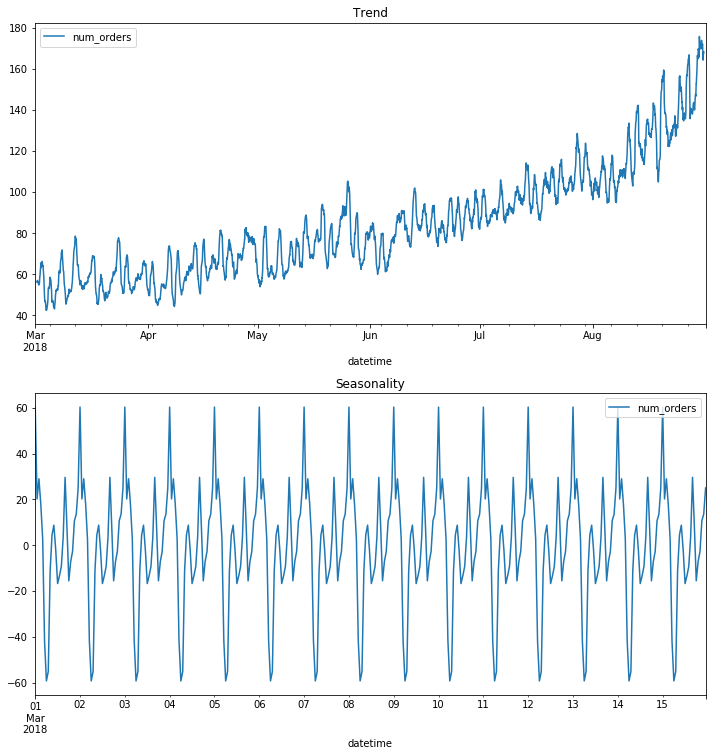

In [6]:
df_sezon_onehour = df_sezon_onehour.resample('1H').sum()
decomposed = seasonal_decompose(df_sezon_onehour)

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.tight_layout()

Как мы отметили ранее, тренд положительный, и сезоность часовая присутствует. Сезоность выраежтся с утра и до ночи. Так же попробуем посмотреть на дневной тренд и сезонность.

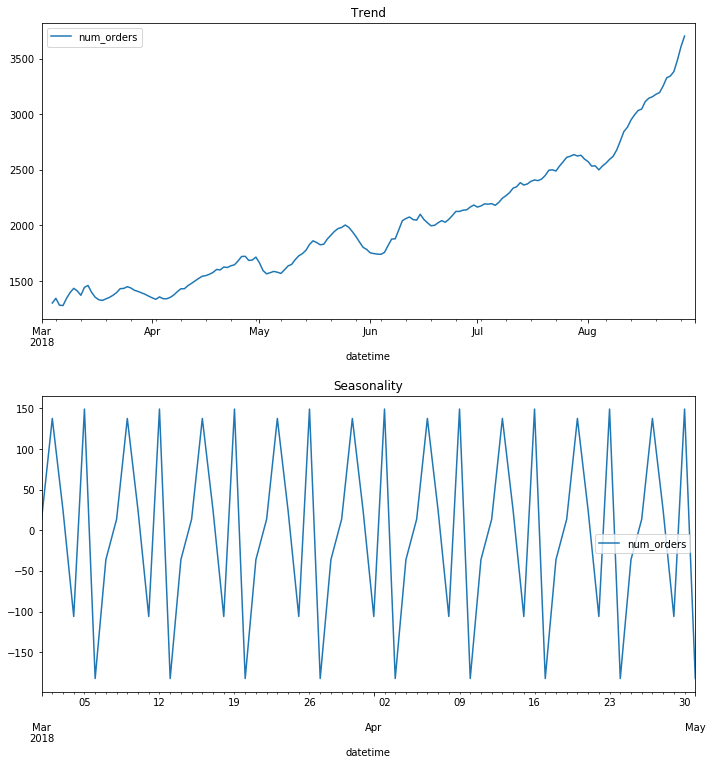

In [7]:
df_sezon_oneday = df_sezon_oneday.resample('1D').sum()
decomposed = seasonal_decompose(df_sezon_oneday)

plt.figure(figsize=(10, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-05-01'].plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.tight_layout()

По дневному ресемплированию тоже видно, что сезонность есть.

Проверим данные на стационарность.

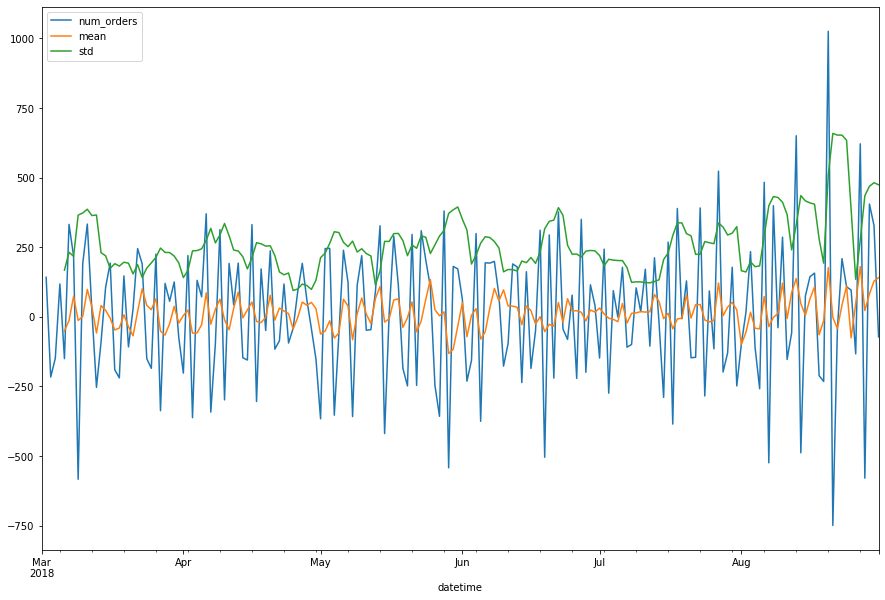

In [8]:
df_rolling -= df_rolling.shift()
df_rolling['mean'] = df_rolling['num_orders'].rolling(5).mean()
df_rolling['std'] = df_rolling['num_orders'].rolling(5).std()

df_rolling[['num_orders', 'mean', 'std']].plot(figsize=(15, 10))
plt.show()

Также проверим стационарность тестом Ад-Фуллера

In [9]:
import statsmodels.api as sm
test = sm.tsa.adfuller(data.iloc[:,0])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027949
p-value:  0.02894005140261345
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


## 3. Обучение

Первым делом необходимо создать признаки, так как в данных имеется только целевой признак.

In [10]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 1, 24)
data.head()

,num_orders,hour,day_of_week,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN
2018-03-01 02:00:00,71,2,3,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,NaN


In [11]:
# удалим из DataFrame строки с пропусками
# чтобы они не попали в обучение
data = data.dropna()

train, test = train_test_split(data, shuffle=False, test_size=.1)

print(train.shape)
print(test.shape)

(3952, 5)
(440, 5)


In [12]:
# DataFrame для добавления результатов моделей
model_result = pd.DataFrame()

In [13]:
# выделим признаки для обучения
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [14]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

predict_lr_train = model_lr.predict(features_train)
rmse_lr_train = mean_squared_error(predict_lr_train, target_train)**0.5

predict_lr_test = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(predict_lr_test, target_test)**0.5

model_result = model_result.append({'Model':'LinearRegression',
                                    'RMSE train':'{:.2f}'.format(rmse_lr_train),
                                    'RMSE test':'{:.2f}'.format(rmse_lr_test)}, ignore_index=True)

In [15]:
tssplit = TimeSeriesSplit().split(features_train)

model_test = ltb.LGBMRegressor(random_state=1)
model_test = RandomForestRegressor(random_state=1)
parametrs = { 'n_estimators': range (151, 201, 10),
             'max_depth': range (1,13, 2)}
gsc = GridSearchCV(model_test, parametrs, scoring='neg_mean_absolute_error', cv=tssplit, verbose=1)
gsc.fit(features_train, target_train)
gsc.best_params_

RandomForestRegressor - {'max_depth': 11, 'n_estimators': 171}

ltb.LGBMRegressor - {'max_depth': 5, 'n_estimators': 100}

In [16]:
model_forest = RandomForestRegressor(n_estimators=170, max_depth=11, random_state=1)
model_forest.fit(features_train, target_train)

predict_forest_train = model_forest.predict(features_train)
rmse_forest_train = mean_squared_error(predict_forest_train, target_train)**0.5

predict_forest_test = model_forest.predict(features_test)
rmse_forest_test = mean_squared_error(predict_forest_test, target_test)**0.5

model_result = model_result.append({'Model':'RandomForestRegressor',
                                    'RMSE train':'{:.2f}'.format(rmse_forest_train),
                                    'RMSE test':'{:.2f}'.format(rmse_forest_test)}, ignore_index=True)

In [17]:
model_lgbm = ltb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=1)
model_lgbm.fit(features_train, target_train)

predict_lgbm_train = model_lgbm.predict(features_train)
rmse_lgbm_train = mean_squared_error(predict_lgbm_train, target_train)**0.5

predict_lgbm_test = model_lgbm.predict(features_test)
rmse_lgbm_test = mean_squared_error(predict_lgbm_test, target_test)**0.5

model_result = model_result.append({'Model':'LGBMRegressor',
                                    'RMSE train':'{:.2f}'.format(rmse_lgbm_train),
                                    'RMSE test':'{:.2f}'.format(rmse_lgbm_test)}, ignore_index=True)

Полученные результаты расссмотрим в следующей главе.

## 4. Тестирование

Рассмотрим получившиеся результаты.

In [18]:
model_result

,Model,RMSE test,RMSE train
0,LinearRegression,51.22,30.91
1,RandomForestRegressor,46.62,14.35
2,LGBMRegressor,42.70,18.73


LGBMRegressor показал самый лучший результат на тестовой выборке.

Рассмотрим в каких местах модель допускает ошибки.

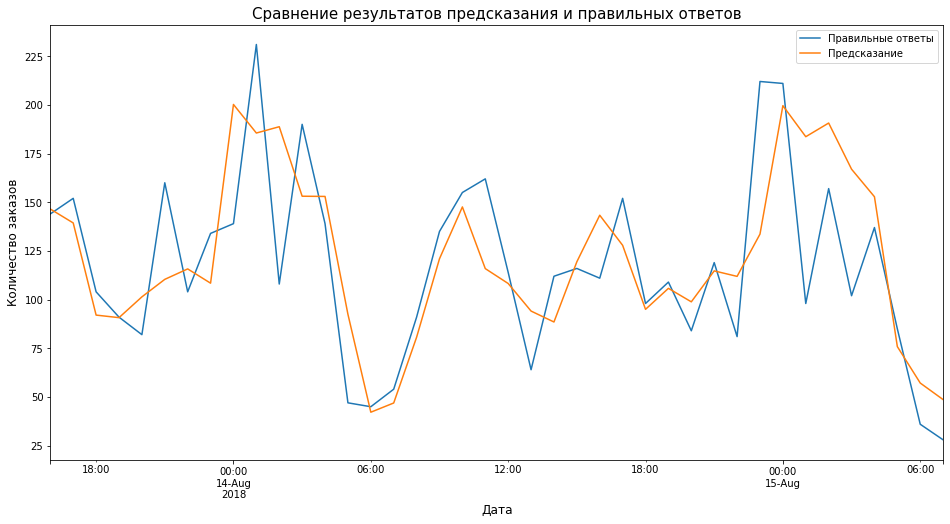

In [19]:
answer = pd.Series(target_test)
predict_model = pd.Series(data=predict_lgbm_test, index=answer.index)

plt.figure(figsize=(16, 8))
answer[:40].plot(label='Правильные ответы')
predict_model[:40].plot(label='Предсказание')
plt.title('Сравнение результатов предсказания и правильных ответов', size=15)
plt.xlabel('Дата', size=12)
plt.ylabel('Количество заказов', size=12)
plt.legend()
plt.show()

Как видно модель сглаживает значения, и не совсем точно попадает по таргету, она больше усредняет ответы.

Посмотрим также какие признаки для модели были наиболее важнимы при обучении и прогнозировании.

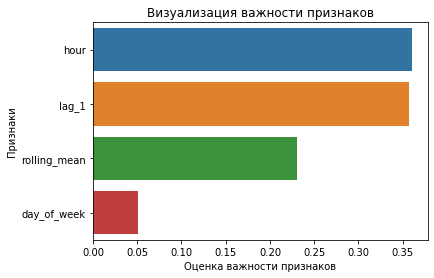

In [23]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_forest)

Как видно это час и lag сдвинутый на 1 час, что довольно логично.

Проанализируем остатки в предсказании модели

1. Свойство симметричности

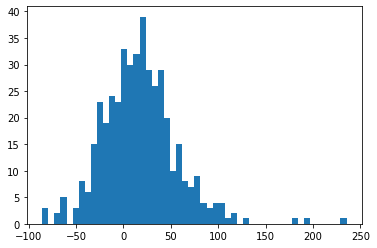

In [25]:
ostatki = answer - predict_model
ostatki.hist(bins=50)  # добавил парамтер bins
plt.grid(False)

Похоже на нормальное распределение с некоторыми отклонениями в хвостах

2. Свойство независимости от предсказанных значений

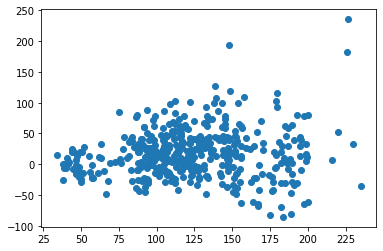

In [24]:
plt.scatter(predict_model, ostatki)

Данное распределение имеет плохой вид, так как точки имеют не однородное распределение. Можно сказать, что данное свойсвто основное. Мы видим, что модель в конце периода хуже работает, чем в начале. А это значит, что надо её улучшать.

3. Свойство отсутствие автокорреляции

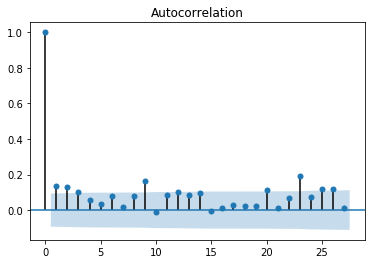

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
ostatki = pd.Series(ostatki) 
plot_acf(ostatki)
plt.show()

График автокорреляций: тут виде "зуб" на первом лаге. По идее, его не должно быть, ведь в модели мы учли фактор лаг = 1. С этим надо разбираться дополнительно.

В целом, если бы свойство 2 (неоднородность остатков) было бы нормальное - можно сказать, что модель не плохо построили, но можно улучшить. А вот это свойство говорит о том, что этой моделью лучше не пользоваться вообще. <div/>
Там дело с фактором тренд, скорее всего. На тестовом периоде рынок изменился и наши продажи начали меняться. А на трайн-периоде этого фактора продаж не было. Поэтому, модель и не знает о нём, поэтому и остатки такие имеем...